The volatility displays several characteristics:


- volatility is positive;
- volatility is mean-reverting, but persists;
- volatility shocks are negatively correlated with asset price shocks. That is, when volatility goes up, stock prices tend to go down and vice-versa.

We analyze a model in which stock prices are conditionally lognormal, and the volatility process is a positive increasing function of a mean-reverting Ornstein-Uhlenbeck (OU) process. That is,

\begin{equation}
\frac{dX_t}{X_t} = \mu dt + f(Y_t) dW_t, 
\end{equation}

\begin{equation}
dY_t = \alpha (m - Y_t) dt + \beta dZ_t, 
\end{equation}

\begin{equation}
Z_t := \rho W_t + \sqrt{1 - \rho^2} Z_t,
\end{equation}

The core goal is to design and train neural networks on GPU Accelerated Monte Carlo-generated datasets, making them scalable and
reusable for a variety of applications. These datasets will act as benchmarks, offering
open access to models that will aid data scientists in developing efficient methods without
requiring deep knowledge of the underlying pricing model.

## Importing Libraries

In [74]:
from numba import cuda
import numpy as np
from scipy.stats import norm
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import os
import copy
import scipy.stats as stats
from sklearn.metrics import r2_score
import polars as pl
import re
device = torch.device('cpu') 


In [104]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [67]:
#dir = ! pwd
#dir = dir[0]

In [68]:
!dir

 Volume in drive D is DATA
 Volume Serial Number is 12D0-7A9C

 Directory of D:\Testing\Validation

02/11/2025  05:13 PM    <DIR>          .
03/17/2025  10:59 AM    <DIR>          ..
10/20/2024  07:04 PM         1,134,930 Tmt0.2500Str0.9752.csv
10/20/2024  07:04 PM         1,134,930 Tmt0.2500Str1.0254.csv
10/20/2024  07:04 PM         1,134,930 Tmt0.2500Str1.0782.csv
10/20/2024  07:04 PM         1,134,930 Tmt0.5000Str0.9570.csv
10/20/2024  07:04 PM         1,134,930 Tmt0.5000Str1.0449.csv
10/20/2024  07:04 PM         1,134,930 Tmt0.5000Str1.1408.csv
10/20/2024  07:04 PM         1,134,930 Tmt1.0000Str0.9217.csv
10/20/2024  07:04 PM         1,134,930 Tmt1.0000Str1.0850.csv
10/20/2024  07:04 PM         1,134,930 Tmt1.0000Str1.2772.csv
10/20/2024  07:04 PM         1,134,930 Tmt1.5000Str0.8876.csv
10/20/2024  07:04 PM         1,134,930 Tmt1.5000Str1.1266.csv
10/20/2024  07:04 PM         1,134,930 Tmt1.5000Str1.4299.csv
10/20/2024  07:04 PM         1,134,930 Tmt2.0000Str0.8548.csv
10/20/2024 

## Inference set division into traning and validation set 

Since the generated data is intended for training neural networks, two files will be produced for VG model: one corresponding to the training set,
and the other for the inference set. The inference set will be divided into test and valida-
tion sets, which will allow us to evaluate how well our neural network model generalizes
to new, unseen data and perform statistical analysis on the test set.


In [77]:
import os
import shutil

# Paths to the folders
inference_data_folder =  'D:/etud/Brice/Testing/Inference'  
testing_data_folder = 'D:/etud/Brice/Testing/Test'      
validation_data_folder = 'D:/etud/Brice/Testing/Validation'    

# Create the testing and validation folders if they don't exist
os.makedirs(testing_data_folder, exist_ok=True)
os.makedirs(validation_data_folder, exist_ok=True)

# List all files in the inference_data folder
files = os.listdir(inference_data_folder)

# Loop through files and distribute them alternately
for i, filename in enumerate(files):
    source_file = os.path.join(inference_data_folder, filename)
    
    if i % 2 == 0:
        destination_folder = testing_data_folder
    else:
        destination_folder = validation_data_folder
    
    # Move the file to the appropriate folder
    shutil.move(source_file, os.path.join(destination_folder, filename))

print("Files have been successfully divided into testing and validation datasets.")


Files have been successfully divided into testing and validation datasets.


## Preprocessing Testing,Validation and Test  Data

In the data preprocessing , we first add two columns specefically for maturity and strike ,then we remove the aberrant values corresponding to the errors which are greater to the prices and finally we randomize the data :

•The generated files only contain the model
parameters, prices, and errors. Maturity and strike values are extracted from the
filenames and appended as new columns.

• Removing aberrant values: First, ensure no null values are present. If there are
zero values, this is acceptable, as zero can be a valid outcome. Aberrant values are
identified as rows where the price is less than the error (indicating that the error is
disproportionately large compared to the price), suggesting that the price might be
inaccurate.

• Randomizing the data: It is crucial to shuffle the data to prevent any structured
order, such as maturities sorted from lowest to highest. If the model is trained on
such structured data, it may fit better to higher maturities while neglecting the
lower ones, hence the importance of randomization.

Those steps will be performed for the training ,validation and test data 

## 1.Preprocessing Test Data

In [78]:
"""""""""""""Data Preprocessing"""""""""""""""""""

"""1.Gathering different execls data in one table and adding maturity and strike parameters  :testing_data """

# Specify the directory containing the CSV files
inference_folder_path = 'D:/etud/Brice/Testing/Test'

# Initialize an empty list to hold all the DataFrames 
data = []

# Loop over all files in the directory
for filename in os.listdir(inference_folder_path):
    
    
        # Extract the base name without the extension
        base_name = os.path.splitext(filename)[0]
        
        # Split the filename based on the known format
        parts = base_name.split('Str')
        
        if len(parts) == 2:
            # Extract maturity and strike parts
            maturity_part = parts[0].replace('Tmt', '').strip()
            strike_part = parts[1].strip()
            
            # Add the DataFrame and the new columns
            file_path = os.path.join(inference_folder_path, filename)
            df = pd.read_csv(file_path)
            df['maturity'] = maturity_part
            df['strike'] = strike_part
            
            # Reorder columns to place 'maturity' and 'strike' as the first two columns
            df = df[['maturity', 'strike'] + [col for col in df.columns if col not in ['maturity', 'strike']]]
            
            # Append DataFrame to the list
            data.append(df)

# Combine all DataFrames into a single DataFrame
inference_table_data = pd.concat(data, ignore_index=True)

# Print the updated DataFrame with 'maturity' and 'strike' as the first two columns
print("Updated DataFrame with 'maturity' and 'strike' as the first two columns:")
print(inference_table_data.columns)





"""2.remove aberrant values: error>price"""
# Create a list to keep track of removed indices
removed_indices = []

# Iterate over the DataFrame rows
for index in range(len(inference_table_data)):
    # Check if "error" is greater than "price" for the current row
 if (inference_table_data.loc[index,' 95cI'] > inference_table_data.loc[index, ' price']):        # Append the index of the row to the removed_indices list
        removed_indices.append(index)

# Drop the rows with indices in removed_indices
inference_table_data = inference_table_data.drop(removed_indices).reset_index(drop=True)

# Print the indices of the removed rows
print(f"Removed rows: {removed_indices}")

# Optionally, print the updated DataFrame
print("Updated DataFrame:")
print(inference_table_data)





"""3.Randomize Data"""

# Shuffle the DataFrame
shuffled_test = inference_table_data.sample(frac=1, random_state=None).reset_index(drop=True)

#Print the shuffled DataFrame
print("Final testing data:")
print(shuffled_test)
# Convert 'maturity' and 'strike' columns to float64
shuffled_test['maturity'] = pd.to_numeric(shuffled_test['maturity'], errors='coerce')
shuffled_test['strike'] = pd.to_numeric(shuffled_test['strike'], errors='coerce')

# Verify the conversion
print(shuffled_test.dtypes)



Updated DataFrame with 'maturity' and 'strike' as the first two columns:
Index(['maturity', 'strike', 'alpha', ' beta', ' m', ' rho', ' Y0', ' price',
       ' 95cI', ' numTraj'],
      dtype='object')
Removed rows: [123119, 145295, 148823, 150478, 152997, 153179, 154292, 154654, 154655, 154686, 154722, 154832, 154902, 155051]
Updated DataFrame:
       maturity  strike  alpha      beta         m   rho        Y0     price  \
0        0.2500  0.9486    0.2  0.313050 -1.203973  0.05 -1.049822  0.097246   
1        0.2500  0.9486    0.2  0.313050 -1.203973  0.05 -1.309333  0.082721   
2        0.2500  0.9486    0.2  0.313050 -1.203973  0.05 -1.609438  0.070421   
3        0.2500  0.9486    0.2  0.313050 -1.203973  0.05 -1.832582  0.063736   
4        0.2500  0.9486    0.2  0.313050 -1.203973  0.05 -2.120264  0.057999   
...         ...     ...    ...       ...       ...   ...       ...       ...   
155501   2.0000  1.3910   25.6  8.237747 -2.813411 -0.95 -1.309333  0.001900   
155502   2.0

## 2.Preprocessing Validation Data

In [79]:
"""""""""""""Data Preprocessing"""""""""""""""""""

"""1.Gathering different execls data in one table : validation_data"""

# Specify the directory containing the CSV files
validation_folder_path = 'D:/etud/Brice//Testing/Validation'

# Initialize an empty list to hold all the DataFrames
data = []

# Loop over all files in the directory
for filename in os.listdir(validation_folder_path):
   
       # Extract the base name without the extension
        base_name = os.path.splitext(filename)[0]
        
        # Split the filename based on the known format
        parts = base_name.split('Str')
        
        if len(parts) == 2:
            # Extract maturity and strike parts
            maturity_part = parts[0].replace('Tmt', '').strip()
            strike_part = parts[1].strip()
            
            # Add the DataFrame and the new columns
            file_path = os.path.join(validation_folder_path, filename)
            df = pd.read_csv(file_path)
            df['maturity'] = maturity_part
            df['strike'] = strike_part
            
            # Reorder columns to place 'maturity' and 'strike' as the first two columns
            df = df[['maturity', 'strike'] + [col for col in df.columns if col not in ['maturity', 'strike']]]
            
            # Append DataFrame to the list
            data.append(df)

# Concatenate all the DataFrames into a single DataFrame
validation_table_data = pd.concat(data, ignore_index=True)





"""2.remove aberrant values: error>price"""
# Create a list to keep track of removed indices
removed_indices = []

# Iterate over the DataFrame rows
for index in range(len(validation_table_data)):
    # Check if "error" is greater than "price" for the current row
    if validation_table_data.loc[index, ' 95cI'] > validation_table_data.loc[index, ' price']:
        # Append the index of the row to the removed_indices list
        removed_indices.append(index)

# Drop the rows with indices in removed_indices
validation_table_data = validation_table_data.drop(removed_indices).reset_index(drop=True)

# Print the indices of the removed rows
print(f"Removed rows: {removed_indices}")

# Optionally, print the updated DataFrame
print("Updated DataFrame:")
print(validation_table_data)





"""3.Randomize Data"""

# Shuffle the DataFrame
shuffled_validation = validation_table_data.sample(frac=1, random_state=None).reset_index(drop=True)

# Print the shuffled DataFrame
print("Final Training Data:")
print(shuffled_validation)

# Convert 'maturity' and 'strike' columns to float64
shuffled_validation['maturity'] = pd.to_numeric(shuffled_validation['maturity'], errors='coerce')
shuffled_validation['strike'] = pd.to_numeric(shuffled_validation['strike'], errors='coerce')

# Verify the conversion
print(shuffled_validation.columns)




Removed rows: [55799, 57635, 59183, 61234, 61703, 85211, 86831, 88450, 88486, 89921, 90573, 90610, 91613, 91649, 91798, 92230, 92261, 92692, 114077, 115846, 115882, 116026, 116098, 116351, 118115, 118151, 118259, 119409, 119553, 119806, 119878, 119948, 120059, 120164, 120983, 121133, 121205, 121281, 121421, 121460, 121890, 122000, 122003, 122142, 122286, 122399, 122711, 122721, 122825, 122969, 123045, 123080, 123116, 123148, 123149, 123187, 123259, 123332, 123364, 123474, 123549, 123616, 123617, 123726, 124005, 124046, 124047, 124195, 124222, 124223, 124224, 124261, 145253, 145289, 145365, 145402, 145474, 145510, 145619, 145727, 146981, 147057, 147310, 147346, 148631, 148673, 148709, 148713, 148929, 149109, 149145, 149289, 149326, 149363, 150437, 150581, 150584, 150656, 150765, 151015, 151088, 151231, 151340, 151342, 151486, 152165, 152240, 152276, 152456, 152527, 152671, 152740, 152741, 152814, 152923, 152924, 152957, 153102, 153172, 153357, 153503, 153815, 153824, 153851, 153893, 153

## 3.Preprocessing Training Data

In [80]:
"""""""""""""Data Preprocessing"""""""""""""""""""

"""1.Gathering different execls data in one table : training_data"""

# Specify the directory containing the CSV files
training_folder_path = 'D:/etud/Brice/Training'

# Initialize an empty list to hold all the DataFrames
data = []

# Loop over all files in the directory
for filename in os.listdir(training_folder_path):
   
       # Extract the base name without the extension
        base_name = os.path.splitext(filename)[0]
        
        # Split the filename based on the known format
        parts = base_name.split('Str')
        
        if len(parts) == 2:
            # Extract maturity and strike parts
            maturity_part = parts[0].replace('Tmt', '').strip()
            strike_part = parts[1].strip()
            
            # Add the DataFrame and the new columns
            file_path = os.path.join(training_folder_path, filename)
            df = pd.read_csv(file_path)
            df['maturity'] = maturity_part
            df['strike'] = strike_part
            
            # Reorder columns to place 'maturity' and 'strike' as the first two columns
            df = df[['maturity', 'strike'] + [col for col in df.columns if col not in ['maturity', 'strike']]]
            
            # Append DataFrame to the list
            data.append(df)

# Concatenate all the DataFrames into a single DataFrame
training_table_data = pd.concat(data, ignore_index=True)

print(training_table_data.columns)



"""2.remove aberrant values: error>price"""
# Create a list to keep track of removed indices
removed_indices = []

# Iterate over the DataFrame rows
for index in range(len(training_table_data)):
    # Check if "error" is greater than "price" for the current row
    if training_table_data.loc[index, ' 95cI'] > training_table_data.loc[index, ' price']:
        # Append the index of the row to the removed_indices list
        removed_indices.append(index)

# Drop the rows with indices in removed_indices
training_table_data = training_table_data.drop(removed_indices).reset_index(drop=True)

# Print the indices of the removed rows
print(f"Removed rows: {removed_indices}")

# Optionally, print the updated DataFrame
print("Updated DataFrame:")
print(training_table_data.columns)





"""3.Randomize Data"""

# Shuffle the DataFrame
shuffled_train = training_table_data.sample(frac=1, random_state=None).reset_index(drop=True)

# Print the shuffled DataFrame
print("Final Training Data:")
print(shuffled_train)

# Convert 'maturity' and 'strike' columns to float64
shuffled_train['maturity'] = pd.to_numeric(shuffled_train['maturity'], errors='coerce')
shuffled_train['strike'] = pd.to_numeric(shuffled_train['strike'], errors='coerce')

# Verify the conversion
print(shuffled_train.columns)




Index(['maturity', 'strike', 'alpha', ' beta', ' m', ' rho', ' Y0', ' price',
       ' 95cI', ' numTraj'],
      dtype='object')
Removed rows: [165707, 486719, 486935, 487115, 494819, 495143, 496367, 496439, 496799, 497123, 497159, 497375, 497519, 642203, 642239, 650303, 650339, 651995, 652175, 652391, 652570, 657035, 657071, 657179, 657215, 657251, 658979, 659159, 660599, 660851, 661283, 662111, 662147, 662687, 663369, 663443, 807875, 808127, 814283, 815939, 816119, 816155, 816227, 816263, 816299, 816515, 817703, 817811, 818171, 818351, 818387, 818531, 818675, 819467, 819503, 821195, 821231, 821375, 822815, 822851, 822887, 822923, 822995, 823067, 823103, 824399, 824867, 826055, 826127, 826451, 826631, 826775, 826847, 826919, 827135, 828430, 828466, 828575, 828682, 828718, 828755, 828791, 828825, 828861, 828934, 828935, 829113, 829151, 971531, 973331, 973367, 973547, 973619, 973871, 978263, 980243, 980315, 981647, 981719, 981935, 982295, 982439, 982475, 984059, 984166, 984238, 984275, 

## Model Establishment

Defining the neural network  model :The neural network model is constructed using the PyTorch framework. It consists of
an input layer, three hidden layers, and an output layer, each fully connected. The
architecture is defined by the class net, where the number of perceptrons in the hidden
layers is configurable. In this implementation, each hidden layer contains 200 perceptrons

In [81]:
#from torch import jit

class net(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_hidden3, n_output, GeLU=False, soft=False):
        """
        :param n_input: number of perceptrons for the input layer (int)
        :param n_hidden: number of perceptrons for the hidden layer (int)
        :param n_output: number of perceptrons for the output layer (int)
        """
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden3 = nn.Linear(n_hidden2, n_hidden3)
        self.output = nn.Linear(n_hidden3, n_output)
        self.nonlin = nn.ReLU()
        if GeLU:
            self.nonlin = nn.GELU()
        self.out = lambda x : x
        if soft:
            self.out = nn.Softplus()


    def forward(self, x):
        """
        :param x: Neural network input (2d torch tensor with arbitrary number of rows and n_input columns)
        :return: 2d torch tensor: Neural network output (same number of rows as x, n_output columns)
        """
        x = self.nonlin(self.hidden1(x))
        x = self.nonlin(self.hidden2(x))
        x = self.nonlin(self.hidden3(x))
        x = self.output(x)
        return self.out(x)  


## NN Model training 

For each pricing model, approximately 10^7 data points are generated, creating a compre-
hensive dataset for training the neural network (NN) mode .

During training, the forward pass through the network generates predictions based on
the input features. The Mean Squared Error (MSE) is utilized as the loss function to
quantify the difference between the predicted and true values. The Adam optimizer, with
a learning rate of 0.001, is employed to update the model weights using backpropagation,
minimizing the loss at each iteration. The model is trained for 100 epochs.


To monitor the best-performing model, a variable is defined to store the model with the
lowest validation loss. A checkpoint is created to save the details and path of this optimal
model.

For both the training and validation sets, their respective losses are concatenated into
two variables, training loss and validation loss, over the 100 epochs. This enables the
plotting of the loss curve for both training and validation losses as a function of the
epochs, providing insight into how the model’s performance improves over time

The shape and dynamics of a learning curve can be used to diagnose the behavior of a
NN model .There are three common dynamics that you are likely to observe in learning curves; they
are:
• Underfit:An underfit model can be identified from the learning curve of the training
loss only.It may show a flat line or noisy values of relatively high loss, indicating
that the model was unable to learn the training dataset at all.

• Overfit:A plot of learning curves shows overfitting if the plot of training loss continues to decrease with experience. The plot of validation
loss decreases to a point and begins increasing again

• Good Fit:A plot of learning curves shows a good fit if the plot of training loss decreases to a point of stability. The plot of validation loss
decreases to a point of stability and has a small gap with the training loss

In [102]:
device = torch.device('cpu') 

In [105]:

input_columns = ['maturity', 'strike', 'alpha', ' beta', ' m', ' rho', ' Y0']  # Select only relevant features
target_column = [ ' price']  # The target column

# 1. Convert training data to PyTorch tensor
X = shuffled_train[input_columns].to_numpy()  # Select input features
y = shuffled_train[target_column].to_numpy()  # Select target variable

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dX_tensor = X_tensor.to(device)
dy_tensor = y_tensor.to(device)

# 2. Convert testing data to PyTorch tensor
X_test = shuffled_test[input_columns].to_numpy()
y_test = shuffled_test[target_column].to_numpy()

test_X_tensor = torch.tensor(X_test, dtype=torch.float32)
test_y_tensor = torch.tensor(y_test, dtype=torch.float32)

# 3. Convert validation data to PyTorch tensor
X_val = shuffled_validation[input_columns].to_numpy()
y_val = shuffled_validation[target_column].to_numpy()

val_X_tensor = torch.tensor(X_val, dtype=torch.float32)
val_y_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create a TensorDataset for training
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

# Create a DataLoader
batch_size = 2048 *8 # Adjust batch size as needed
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the neural network
n_input = X_tensor.shape[1]
n_output = 1

model = net(n_input, 200, 200, 200, n_output, True, True)  # Adjust hidden layers as needed

# Define the loss function and optimizer
loss_func = torch.nn.MSELoss(reduction='mean')  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Initialize the checkpoint save directory
checkpoint_dir = 'D:/etud/Brice/alt4_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Initialize variables for storing the best model
best_loss = float('inf')
best_model_path = None  # To store the path of the best model
best_epoch = -1

# Training loop with checkpoint
epochs = 1000
train_losses = []
val_losses = []
test_losses = []

model.to(device)
val_X_tensor = val_X_tensor.to(device)
val_y_tensor = val_y_tensor.to(device)
test_X_tensor = test_X_tensor.to(device)
test_y_tensor = test_y_tensor.to(device)

for epoch in tqdm(range(epochs)):
    model.train()
    num_batch = X_tensor.shape[0] // batch_size
    #for batch_X, batch_y in dataloader:
    #    batch_X = batch_X.to(device)
    #    batch_y = batch_y.to(device)
    for i in range(num_batch):
        batch_X = dX_tensor[i*batch_size:min((i+1)*batch_size, dX_tensor.shape[0])]
        batch_y = dy_tensor[i*batch_size:min((i+1)*batch_size, dX_tensor.shape[0])]
        optimizer.zero_grad()
        output = model(batch_X)
        loss = loss_func(output, batch_y)
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Calculate training loss for the epoch
    train_loss = loss.item()

    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(val_X_tensor)
        val_loss = loss_func(val_predictions, val_y_tensor)

        # Evaluate on the test set
        test_predictions = model(test_X_tensor)
        test_loss = loss_func(test_predictions, test_y_tensor)

    # Store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())
    test_losses.append(test_loss.item())

    # Print epoch information
    #print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss.item()}, Test Loss: {test_loss.item()}')

    # Check if the validation loss is the best so far
    if val_loss < best_loss:
        # Update the best loss
        best_loss = val_loss
        best_model = copy.deepcopy(model)  # Save a copy of the best model

        best_epoch = epoch + 1

        # Save the best model
        best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

        # Remove the previous checkpoint if it exists
        if os.path.exists(best_model_path):
            os.remove(best_model_path)

        # Save the current best model
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_loss.item(),
        }, best_model_path)

        # Save metadata in a human-readable format
        metadata_path = os.path.join(checkpoint_dir, 'best_model_metadata.txt')
        with open(metadata_path, 'w') as metadata_file:
            metadata = {
                'best_epoch': best_epoch,
                'best_val_loss': best_loss.item(),
            }
            json.dump(metadata, metadata_file, indent=4)

        print(f'Best model checkpoint saved at epoch {best_epoch} with validation loss {best_loss.item():.10f}')

print("Training completed!")
print(f'Best Validation Loss: {best_loss.item():.10f} at Epoch {best_epoch}')

  0%|                                                                                 | 1/1000 [00:00<08:33,  1.95it/s]

Best model checkpoint saved at epoch 1 with validation loss 0.0042569609


  0%|▏                                                                                | 2/1000 [00:00<06:29,  2.56it/s]

Best model checkpoint saved at epoch 2 with validation loss 0.0006655035


  0%|▏                                                                                | 3/1000 [00:01<05:34,  2.98it/s]

Best model checkpoint saved at epoch 3 with validation loss 0.0003776390


  0%|▎                                                                                | 4/1000 [00:01<05:19,  3.11it/s]

Best model checkpoint saved at epoch 4 with validation loss 0.0003153704


  0%|▍                                                                                | 5/1000 [00:01<04:59,  3.32it/s]

Best model checkpoint saved at epoch 5 with validation loss 0.0003039250


  1%|▍                                                                                | 6/1000 [00:01<04:50,  3.42it/s]

Best model checkpoint saved at epoch 6 with validation loss 0.0002291388


  1%|▌                                                                                | 7/1000 [00:02<04:43,  3.50it/s]

Best model checkpoint saved at epoch 7 with validation loss 0.0001767323


  1%|▋                                                                                | 8/1000 [00:02<04:44,  3.49it/s]

Best model checkpoint saved at epoch 8 with validation loss 0.0001457170


  1%|▋                                                                                | 9/1000 [00:02<04:37,  3.58it/s]

Best model checkpoint saved at epoch 9 with validation loss 0.0001087307


  1%|▊                                                                               | 10/1000 [00:03<04:38,  3.56it/s]

Best model checkpoint saved at epoch 10 with validation loss 0.0000925088


  1%|▉                                                                               | 11/1000 [00:03<04:51,  3.39it/s]

Best model checkpoint saved at epoch 11 with validation loss 0.0000903895


  1%|▉                                                                               | 12/1000 [00:03<04:44,  3.47it/s]

Best model checkpoint saved at epoch 12 with validation loss 0.0000561172


  1%|█                                                                               | 14/1000 [00:04<04:35,  3.58it/s]

Best model checkpoint saved at epoch 14 with validation loss 0.0000508708


  2%|█▏                                                                              | 15/1000 [00:04<04:31,  3.63it/s]

Best model checkpoint saved at epoch 15 with validation loss 0.0000435229


  2%|█▎                                                                              | 17/1000 [00:04<04:14,  3.86it/s]

Best model checkpoint saved at epoch 17 with validation loss 0.0000351238


  2%|█▌                                                                              | 19/1000 [00:05<04:08,  3.95it/s]

Best model checkpoint saved at epoch 19 with validation loss 0.0000314615


  2%|█▌                                                                              | 20/1000 [00:05<04:11,  3.90it/s]

Best model checkpoint saved at epoch 20 with validation loss 0.0000264649


  2%|█▊                                                                              | 22/1000 [00:06<04:05,  3.98it/s]

Best model checkpoint saved at epoch 22 with validation loss 0.0000213054


  2%|█▊                                                                              | 23/1000 [00:06<04:08,  3.93it/s]

Best model checkpoint saved at epoch 23 with validation loss 0.0000177717


  2%|█▉                                                                              | 24/1000 [00:06<04:13,  3.85it/s]

Best model checkpoint saved at epoch 24 with validation loss 0.0000176890


  3%|██▏                                                                             | 28/1000 [00:07<04:04,  3.97it/s]

Best model checkpoint saved at epoch 28 with validation loss 0.0000135750


  3%|██▍                                                                             | 31/1000 [00:08<04:12,  3.83it/s]

Best model checkpoint saved at epoch 31 with validation loss 0.0000106890


  4%|██▊                                                                             | 35/1000 [00:09<04:11,  3.84it/s]

Best model checkpoint saved at epoch 35 with validation loss 0.0000085115


  4%|███▏                                                                            | 40/1000 [00:10<04:11,  3.81it/s]

Best model checkpoint saved at epoch 40 with validation loss 0.0000082117


  4%|███▎                                                                            | 42/1000 [00:11<04:09,  3.84it/s]

Best model checkpoint saved at epoch 42 with validation loss 0.0000071550


  5%|███▋                                                                            | 46/1000 [00:12<04:05,  3.88it/s]

Best model checkpoint saved at epoch 46 with validation loss 0.0000060386


  5%|████                                                                            | 50/1000 [00:13<04:06,  3.85it/s]

Best model checkpoint saved at epoch 50 with validation loss 0.0000052959


  5%|████▎                                                                           | 54/1000 [00:14<03:59,  3.95it/s]

Best model checkpoint saved at epoch 54 with validation loss 0.0000051242


  6%|████▍                                                                           | 55/1000 [00:14<03:58,  3.96it/s]

Best model checkpoint saved at epoch 55 with validation loss 0.0000041588


  6%|█████                                                                           | 64/1000 [00:16<03:52,  4.02it/s]

Best model checkpoint saved at epoch 64 with validation loss 0.0000027538


  7%|█████▎                                                                          | 67/1000 [00:17<04:12,  3.70it/s]

Best model checkpoint saved at epoch 67 with validation loss 0.0000026786


  7%|█████▋                                                                          | 71/1000 [00:19<04:39,  3.32it/s]

Best model checkpoint saved at epoch 71 with validation loss 0.0000022776


  7%|█████▊                                                                          | 72/1000 [00:19<04:44,  3.26it/s]

Best model checkpoint saved at epoch 72 with validation loss 0.0000022370


  8%|██████▍                                                                         | 80/1000 [00:21<04:55,  3.12it/s]

Best model checkpoint saved at epoch 80 with validation loss 0.0000017122


  8%|██████▋                                                                         | 84/1000 [00:23<04:53,  3.12it/s]

Best model checkpoint saved at epoch 84 with validation loss 0.0000015326


 10%|███████▌                                                                        | 95/1000 [00:26<04:50,  3.11it/s]

Best model checkpoint saved at epoch 95 with validation loss 0.0000012411


 11%|████████▌                                                                      | 109/1000 [00:31<04:26,  3.35it/s]

Best model checkpoint saved at epoch 109 with validation loss 0.0000009940


 11%|████████▉                                                                      | 113/1000 [00:32<04:38,  3.19it/s]

Best model checkpoint saved at epoch 113 with validation loss 0.0000009924


 12%|█████████▉                                                                     | 125/1000 [00:36<04:36,  3.17it/s]

Best model checkpoint saved at epoch 125 with validation loss 0.0000007684


 15%|███████████▊                                                                   | 150/1000 [00:43<04:25,  3.20it/s]

Best model checkpoint saved at epoch 150 with validation loss 0.0000007106


 15%|████████████▏                                                                  | 154/1000 [00:45<04:25,  3.19it/s]

Best model checkpoint saved at epoch 154 with validation loss 0.0000006253


 17%|█████████████▌                                                                 | 171/1000 [00:50<03:46,  3.65it/s]

Best model checkpoint saved at epoch 171 with validation loss 0.0000005456


 18%|█████████████▊                                                                 | 175/1000 [00:51<03:35,  3.83it/s]

Best model checkpoint saved at epoch 175 with validation loss 0.0000005416


 19%|██████████████▋                                                                | 186/1000 [00:54<03:45,  3.61it/s]

Best model checkpoint saved at epoch 186 with validation loss 0.0000005329


 20%|███████████████▉                                                               | 201/1000 [00:58<03:25,  3.89it/s]

Best model checkpoint saved at epoch 201 with validation loss 0.0000004412


 21%|████████████████▎                                                              | 207/1000 [00:59<03:34,  3.70it/s]

Best model checkpoint saved at epoch 207 with validation loss 0.0000004389


 40%|███████████████████████████████▋                                               | 401/1000 [01:56<02:32,  3.92it/s]

Best model checkpoint saved at epoch 401 with validation loss 0.0000003247


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:55<02:09,  3.07it/s]

Best model checkpoint saved at epoch 601 with validation loss 0.0000003058


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:55<02:08,  3.09it/s]

Best model checkpoint saved at epoch 603 with validation loss 0.0000003033


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:56<02:08,  3.09it/s]

Best model checkpoint saved at epoch 604 with validation loss 0.0000003026


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [03:28<01:33,  3.14it/s]

Best model checkpoint saved at epoch 706 with validation loss 0.0000003026


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [03:29<01:32,  3.18it/s]

Best model checkpoint saved at epoch 707 with validation loss 0.0000003025


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [03:29<01:32,  3.15it/s]

Best model checkpoint saved at epoch 708 with validation loss 0.0000003025


 71%|████████████████████████████████████████████████████████                       | 709/1000 [03:29<01:32,  3.16it/s]

Best model checkpoint saved at epoch 709 with validation loss 0.0000003024


 71%|████████████████████████████████████████████████████████                       | 710/1000 [03:30<01:30,  3.20it/s]

Best model checkpoint saved at epoch 710 with validation loss 0.0000003024


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [03:30<01:31,  3.16it/s]

Best model checkpoint saved at epoch 711 with validation loss 0.0000003024


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [03:30<01:31,  3.13it/s]

Best model checkpoint saved at epoch 712 with validation loss 0.0000003023


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [03:30<01:30,  3.18it/s]

Best model checkpoint saved at epoch 713 with validation loss 0.0000003023


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [03:31<01:30,  3.15it/s]

Best model checkpoint saved at epoch 714 with validation loss 0.0000003023


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [03:31<01:31,  3.13it/s]

Best model checkpoint saved at epoch 715 with validation loss 0.0000003022


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [03:31<01:28,  3.20it/s]

Best model checkpoint saved at epoch 716 with validation loss 0.0000003022


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [03:32<01:29,  3.16it/s]

Best model checkpoint saved at epoch 717 with validation loss 0.0000003021


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [03:32<01:29,  3.14it/s]

Best model checkpoint saved at epoch 718 with validation loss 0.0000003021


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [03:32<01:25,  3.28it/s]

Best model checkpoint saved at epoch 719 with validation loss 0.0000003021


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [03:33<01:27,  3.21it/s]

Best model checkpoint saved at epoch 720 with validation loss 0.0000003020


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [03:33<01:27,  3.18it/s]

Best model checkpoint saved at epoch 721 with validation loss 0.0000003020


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [03:33<01:26,  3.21it/s]

Best model checkpoint saved at epoch 722 with validation loss 0.0000003020


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [03:34<01:24,  3.26it/s]

Best model checkpoint saved at epoch 723 with validation loss 0.0000003019


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [03:34<01:26,  3.20it/s]

Best model checkpoint saved at epoch 724 with validation loss 0.0000003019


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [03:34<01:26,  3.16it/s]

Best model checkpoint saved at epoch 725 with validation loss 0.0000003018


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [03:35<01:24,  3.23it/s]

Best model checkpoint saved at epoch 726 with validation loss 0.0000003018


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [03:35<01:25,  3.21it/s]

Best model checkpoint saved at epoch 727 with validation loss 0.0000003018


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [03:35<01:22,  3.30it/s]

Best model checkpoint saved at epoch 728 with validation loss 0.0000003017


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [03:35<01:22,  3.29it/s]

Best model checkpoint saved at epoch 729 with validation loss 0.0000003017


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [03:36<01:21,  3.32it/s]

Best model checkpoint saved at epoch 730 with validation loss 0.0000003017


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [03:36<01:22,  3.28it/s]

Best model checkpoint saved at epoch 731 with validation loss 0.0000003016


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [03:36<01:22,  3.25it/s]

Best model checkpoint saved at epoch 732 with validation loss 0.0000003016


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [03:37<01:22,  3.22it/s]

Best model checkpoint saved at epoch 733 with validation loss 0.0000003015


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [03:37<01:23,  3.20it/s]

Best model checkpoint saved at epoch 734 with validation loss 0.0000003015


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [03:37<01:24,  3.13it/s]

Best model checkpoint saved at epoch 735 with validation loss 0.0000003015


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [03:38<01:23,  3.15it/s]

Best model checkpoint saved at epoch 736 with validation loss 0.0000003014


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [03:38<01:24,  3.11it/s]

Best model checkpoint saved at epoch 737 with validation loss 0.0000003014


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [03:38<01:24,  3.09it/s]

Best model checkpoint saved at epoch 738 with validation loss 0.0000003014


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [03:39<01:21,  3.21it/s]

Best model checkpoint saved at epoch 739 with validation loss 0.0000003013


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [03:39<01:21,  3.20it/s]

Best model checkpoint saved at epoch 740 with validation loss 0.0000003013


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [03:39<01:21,  3.16it/s]

Best model checkpoint saved at epoch 741 with validation loss 0.0000003013


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [03:40<01:20,  3.19it/s]

Best model checkpoint saved at epoch 742 with validation loss 0.0000003012


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [03:40<01:19,  3.25it/s]

Best model checkpoint saved at epoch 743 with validation loss 0.0000003012


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [03:40<01:19,  3.23it/s]

Best model checkpoint saved at epoch 744 with validation loss 0.0000003011


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:40<01:19,  3.21it/s]

Best model checkpoint saved at epoch 745 with validation loss 0.0000003011


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [03:41<01:20,  3.17it/s]

Best model checkpoint saved at epoch 746 with validation loss 0.0000003011


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [03:41<01:20,  3.14it/s]

Best model checkpoint saved at epoch 747 with validation loss 0.0000003010


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [03:41<01:21,  3.09it/s]

Best model checkpoint saved at epoch 748 with validation loss 0.0000003010


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [03:42<01:19,  3.15it/s]

Best model checkpoint saved at epoch 749 with validation loss 0.0000003010


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [03:42<01:19,  3.13it/s]

Best model checkpoint saved at epoch 750 with validation loss 0.0000003009


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [03:42<01:19,  3.12it/s]

Best model checkpoint saved at epoch 751 with validation loss 0.0000003009


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [03:43<01:16,  3.23it/s]

Best model checkpoint saved at epoch 752 with validation loss 0.0000003009


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [03:43<01:16,  3.21it/s]

Best model checkpoint saved at epoch 753 with validation loss 0.0000003008


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [03:43<01:17,  3.17it/s]

Best model checkpoint saved at epoch 754 with validation loss 0.0000003008


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [03:44<01:17,  3.14it/s]

Best model checkpoint saved at epoch 755 with validation loss 0.0000003008


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [03:44<01:15,  3.22it/s]

Best model checkpoint saved at epoch 756 with validation loss 0.0000003007


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [03:44<01:16,  3.17it/s]

Best model checkpoint saved at epoch 757 with validation loss 0.0000003007


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [03:45<01:16,  3.18it/s]

Best model checkpoint saved at epoch 758 with validation loss 0.0000003007


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [03:45<01:16,  3.15it/s]

Best model checkpoint saved at epoch 759 with validation loss 0.0000003006


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [03:45<01:16,  3.12it/s]

Best model checkpoint saved at epoch 760 with validation loss 0.0000003006


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [03:46<01:15,  3.17it/s]

Best model checkpoint saved at epoch 761 with validation loss 0.0000003006


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [03:46<01:14,  3.20it/s]

Best model checkpoint saved at epoch 762 with validation loss 0.0000003005


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [03:46<01:14,  3.16it/s]

Best model checkpoint saved at epoch 763 with validation loss 0.0000003005


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [03:46<01:15,  3.11it/s]

Best model checkpoint saved at epoch 764 with validation loss 0.0000003005


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [03:47<01:13,  3.21it/s]

Best model checkpoint saved at epoch 765 with validation loss 0.0000003004


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [03:47<01:13,  3.18it/s]

Best model checkpoint saved at epoch 766 with validation loss 0.0000003004


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [03:47<01:13,  3.15it/s]

Best model checkpoint saved at epoch 767 with validation loss 0.0000003004


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [03:48<01:11,  3.25it/s]

Best model checkpoint saved at epoch 768 with validation loss 0.0000003003


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [03:48<01:07,  3.42it/s]

Best model checkpoint saved at epoch 769 with validation loss 0.0000003003


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [03:48<01:06,  3.47it/s]

Best model checkpoint saved at epoch 770 with validation loss 0.0000003003


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [03:48<01:03,  3.59it/s]

Best model checkpoint saved at epoch 771 with validation loss 0.0000003002


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [03:49<01:03,  3.60it/s]

Best model checkpoint saved at epoch 772 with validation loss 0.0000003002


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [03:49<01:05,  3.48it/s]

Best model checkpoint saved at epoch 773 with validation loss 0.0000003002


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [03:49<01:02,  3.60it/s]

Best model checkpoint saved at epoch 774 with validation loss 0.0000003001


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [03:50<01:04,  3.49it/s]

Best model checkpoint saved at epoch 775 with validation loss 0.0000003001


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [03:50<01:02,  3.56it/s]

Best model checkpoint saved at epoch 776 with validation loss 0.0000003001


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [03:50<01:01,  3.60it/s]

Best model checkpoint saved at epoch 777 with validation loss 0.0000003000


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [03:50<00:59,  3.74it/s]

Best model checkpoint saved at epoch 778 with validation loss 0.0000003000


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [03:51<01:01,  3.58it/s]

Best model checkpoint saved at epoch 779 with validation loss 0.0000003000


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [03:51<01:04,  3.40it/s]

Best model checkpoint saved at epoch 780 with validation loss 0.0000002999


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [03:51<01:02,  3.53it/s]

Best model checkpoint saved at epoch 781 with validation loss 0.0000002999


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [03:52<01:00,  3.59it/s]

Best model checkpoint saved at epoch 782 with validation loss 0.0000002999


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [03:52<00:59,  3.68it/s]

Best model checkpoint saved at epoch 783 with validation loss 0.0000002998


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [03:52<00:57,  3.78it/s]

Best model checkpoint saved at epoch 784 with validation loss 0.0000002998


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [03:52<00:56,  3.81it/s]

Best model checkpoint saved at epoch 785 with validation loss 0.0000002998


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [03:53<00:55,  3.88it/s]

Best model checkpoint saved at epoch 786 with validation loss 0.0000002997


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [03:53<00:55,  3.84it/s]

Best model checkpoint saved at epoch 787 with validation loss 0.0000002997


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [03:53<00:54,  3.89it/s]

Best model checkpoint saved at epoch 788 with validation loss 0.0000002997


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [03:53<00:54,  3.86it/s]

Best model checkpoint saved at epoch 789 with validation loss 0.0000002996


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [03:54<00:54,  3.87it/s]

Best model checkpoint saved at epoch 790 with validation loss 0.0000002996


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [03:54<00:53,  3.87it/s]

Best model checkpoint saved at epoch 791 with validation loss 0.0000002996


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [03:54<00:58,  3.58it/s]

Best model checkpoint saved at epoch 792 with validation loss 0.0000002995


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [03:54<00:57,  3.58it/s]

Best model checkpoint saved at epoch 793 with validation loss 0.0000002995


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [03:55<00:56,  3.64it/s]

Best model checkpoint saved at epoch 794 with validation loss 0.0000002995


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [03:55<00:55,  3.71it/s]

Best model checkpoint saved at epoch 795 with validation loss 0.0000002994


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [03:55<00:55,  3.68it/s]

Best model checkpoint saved at epoch 796 with validation loss 0.0000002994


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [03:56<00:53,  3.79it/s]

Best model checkpoint saved at epoch 797 with validation loss 0.0000002994


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [03:56<00:53,  3.81it/s]

Best model checkpoint saved at epoch 798 with validation loss 0.0000002993


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [03:56<00:52,  3.80it/s]

Best model checkpoint saved at epoch 799 with validation loss 0.0000002993


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [03:56<00:51,  3.86it/s]

Best model checkpoint saved at epoch 800 with validation loss 0.0000002993


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:57<00:56,  3.53it/s]

Best model checkpoint saved at epoch 801 with validation loss 0.0000002943


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [03:57<00:56,  3.53it/s]

Best model checkpoint saved at epoch 802 with validation loss 0.0000002936


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [03:58<00:47,  4.05it/s]

Best model checkpoint saved at epoch 807 with validation loss 0.0000002933


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [04:13<00:35,  3.87it/s]

Best model checkpoint saved at epoch 861 with validation loss 0.0000002933


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [04:13<00:36,  3.76it/s]

Best model checkpoint saved at epoch 862 with validation loss 0.0000002932


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [04:13<00:35,  3.81it/s]

Best model checkpoint saved at epoch 863 with validation loss 0.0000002932


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [04:14<00:35,  3.86it/s]

Best model checkpoint saved at epoch 864 with validation loss 0.0000002932


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [04:14<00:35,  3.78it/s]

Best model checkpoint saved at epoch 865 with validation loss 0.0000002932


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [04:14<00:35,  3.79it/s]

Best model checkpoint saved at epoch 866 with validation loss 0.0000002932


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [04:14<00:34,  3.85it/s]

Best model checkpoint saved at epoch 867 with validation loss 0.0000002932


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [04:15<00:34,  3.83it/s]

Best model checkpoint saved at epoch 868 with validation loss 0.0000002931


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [04:15<00:35,  3.71it/s]

Best model checkpoint saved at epoch 869 with validation loss 0.0000002931


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [04:15<00:34,  3.75it/s]

Best model checkpoint saved at epoch 870 with validation loss 0.0000002931


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [04:15<00:35,  3.64it/s]

Best model checkpoint saved at epoch 871 with validation loss 0.0000002931


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [04:16<00:34,  3.74it/s]

Best model checkpoint saved at epoch 872 with validation loss 0.0000002931


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [04:16<00:33,  3.83it/s]

Best model checkpoint saved at epoch 873 with validation loss 0.0000002930


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [04:16<00:32,  3.85it/s]

Best model checkpoint saved at epoch 874 with validation loss 0.0000002930


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [04:16<00:32,  3.86it/s]

Best model checkpoint saved at epoch 875 with validation loss 0.0000002930


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [04:17<00:32,  3.87it/s]

Best model checkpoint saved at epoch 876 with validation loss 0.0000002930


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [04:17<00:31,  3.87it/s]

Best model checkpoint saved at epoch 877 with validation loss 0.0000002930


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [04:17<00:31,  3.88it/s]

Best model checkpoint saved at epoch 878 with validation loss 0.0000002929


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [04:18<00:30,  3.93it/s]

Best model checkpoint saved at epoch 879 with validation loss 0.0000002929


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [04:18<00:30,  3.97it/s]

Best model checkpoint saved at epoch 880 with validation loss 0.0000002929


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [04:18<00:32,  3.69it/s]

Best model checkpoint saved at epoch 881 with validation loss 0.0000002929


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [04:18<00:33,  3.55it/s]

Best model checkpoint saved at epoch 882 with validation loss 0.0000002929


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [04:19<00:34,  3.38it/s]

Best model checkpoint saved at epoch 883 with validation loss 0.0000002929


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [04:19<00:35,  3.28it/s]

Best model checkpoint saved at epoch 884 with validation loss 0.0000002928


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [04:19<00:35,  3.28it/s]

Best model checkpoint saved at epoch 885 with validation loss 0.0000002928


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [04:20<00:35,  3.24it/s]

Best model checkpoint saved at epoch 886 with validation loss 0.0000002928


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [04:20<00:34,  3.32it/s]

Best model checkpoint saved at epoch 887 with validation loss 0.0000002928


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [04:20<00:33,  3.30it/s]

Best model checkpoint saved at epoch 888 with validation loss 0.0000002928


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [04:21<00:32,  3.37it/s]

Best model checkpoint saved at epoch 889 with validation loss 0.0000002927


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [04:21<00:33,  3.29it/s]

Best model checkpoint saved at epoch 890 with validation loss 0.0000002927


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [04:21<00:32,  3.32it/s]

Best model checkpoint saved at epoch 891 with validation loss 0.0000002927


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [04:21<00:33,  3.27it/s]

Best model checkpoint saved at epoch 892 with validation loss 0.0000002927


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [04:22<00:33,  3.24it/s]

Best model checkpoint saved at epoch 893 with validation loss 0.0000002927


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [04:22<00:33,  3.18it/s]

Best model checkpoint saved at epoch 894 with validation loss 0.0000002927


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [04:22<00:32,  3.20it/s]

Best model checkpoint saved at epoch 895 with validation loss 0.0000002926


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [04:23<00:32,  3.16it/s]

Best model checkpoint saved at epoch 896 with validation loss 0.0000002926


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [04:23<00:32,  3.13it/s]

Best model checkpoint saved at epoch 897 with validation loss 0.0000002926


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [04:23<00:32,  3.11it/s]

Best model checkpoint saved at epoch 898 with validation loss 0.0000002926


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [04:24<00:32,  3.10it/s]

Best model checkpoint saved at epoch 899 with validation loss 0.0000002926


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [04:24<00:32,  3.08it/s]

Best model checkpoint saved at epoch 900 with validation loss 0.0000002925


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [04:24<00:31,  3.14it/s]

Best model checkpoint saved at epoch 901 with validation loss 0.0000002925


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [04:25<00:31,  3.11it/s]

Best model checkpoint saved at epoch 902 with validation loss 0.0000002925


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [04:25<00:31,  3.13it/s]

Best model checkpoint saved at epoch 903 with validation loss 0.0000002925


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [04:25<00:29,  3.23it/s]

Best model checkpoint saved at epoch 904 with validation loss 0.0000002925


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [04:26<00:29,  3.24it/s]

Best model checkpoint saved at epoch 905 with validation loss 0.0000002925


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [04:26<00:29,  3.18it/s]

Best model checkpoint saved at epoch 906 with validation loss 0.0000002924


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [04:26<00:29,  3.15it/s]

Best model checkpoint saved at epoch 907 with validation loss 0.0000002924


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [04:27<00:29,  3.09it/s]

Best model checkpoint saved at epoch 908 with validation loss 0.0000002924


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [04:27<00:29,  3.08it/s]

Best model checkpoint saved at epoch 909 with validation loss 0.0000002924


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [04:27<00:29,  3.04it/s]

Best model checkpoint saved at epoch 910 with validation loss 0.0000002924


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [04:28<00:28,  3.17it/s]

Best model checkpoint saved at epoch 911 with validation loss 0.0000002924


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [04:28<00:27,  3.17it/s]

Best model checkpoint saved at epoch 912 with validation loss 0.0000002923


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [04:28<00:27,  3.20it/s]

Best model checkpoint saved at epoch 913 with validation loss 0.0000002923


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [04:28<00:26,  3.28it/s]

Best model checkpoint saved at epoch 914 with validation loss 0.0000002923


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [04:29<00:25,  3.31it/s]

Best model checkpoint saved at epoch 915 with validation loss 0.0000002923


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [04:29<00:25,  3.26it/s]

Best model checkpoint saved at epoch 916 with validation loss 0.0000002923


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [04:29<00:25,  3.29it/s]

Best model checkpoint saved at epoch 917 with validation loss 0.0000002922


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [04:30<00:25,  3.22it/s]

Best model checkpoint saved at epoch 918 with validation loss 0.0000002922


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [04:30<00:25,  3.17it/s]

Best model checkpoint saved at epoch 919 with validation loss 0.0000002922


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [04:30<00:25,  3.20it/s]

Best model checkpoint saved at epoch 920 with validation loss 0.0000002922


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [04:31<00:24,  3.25it/s]

Best model checkpoint saved at epoch 921 with validation loss 0.0000002922


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [04:31<00:22,  3.45it/s]

Best model checkpoint saved at epoch 922 with validation loss 0.0000002922


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [04:31<00:22,  3.36it/s]

Best model checkpoint saved at epoch 923 with validation loss 0.0000002921


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [04:31<00:22,  3.37it/s]

Best model checkpoint saved at epoch 924 with validation loss 0.0000002921


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [04:32<00:21,  3.56it/s]

Best model checkpoint saved at epoch 925 with validation loss 0.0000002921


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [04:32<00:20,  3.69it/s]

Best model checkpoint saved at epoch 926 with validation loss 0.0000002921


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [04:32<00:19,  3.76it/s]

Best model checkpoint saved at epoch 927 with validation loss 0.0000002921


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [04:32<00:19,  3.64it/s]

Best model checkpoint saved at epoch 928 with validation loss 0.0000002921


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [04:33<00:19,  3.56it/s]

Best model checkpoint saved at epoch 929 with validation loss 0.0000002920


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [04:33<00:19,  3.65it/s]

Best model checkpoint saved at epoch 930 with validation loss 0.0000002920


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [04:33<00:19,  3.61it/s]

Best model checkpoint saved at epoch 931 with validation loss 0.0000002920


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [04:34<00:20,  3.39it/s]

Best model checkpoint saved at epoch 932 with validation loss 0.0000002920


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [04:34<00:20,  3.29it/s]

Best model checkpoint saved at epoch 933 with validation loss 0.0000002920


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [04:34<00:20,  3.28it/s]

Best model checkpoint saved at epoch 934 with validation loss 0.0000002920


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [04:35<00:20,  3.21it/s]

Best model checkpoint saved at epoch 935 with validation loss 0.0000002919


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [04:35<00:20,  3.17it/s]

Best model checkpoint saved at epoch 936 with validation loss 0.0000002919


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [04:35<00:20,  3.08it/s]

Best model checkpoint saved at epoch 937 with validation loss 0.0000002919


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [04:36<00:19,  3.13it/s]

Best model checkpoint saved at epoch 938 with validation loss 0.0000002919


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [04:36<00:19,  3.08it/s]

Best model checkpoint saved at epoch 939 with validation loss 0.0000002919


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [04:36<00:19,  3.08it/s]

Best model checkpoint saved at epoch 940 with validation loss 0.0000002919


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [04:37<00:19,  3.01it/s]

Best model checkpoint saved at epoch 941 with validation loss 0.0000002918


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [04:37<00:19,  3.03it/s]

Best model checkpoint saved at epoch 942 with validation loss 0.0000002918


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [04:37<00:18,  3.04it/s]

Best model checkpoint saved at epoch 943 with validation loss 0.0000002918


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [04:38<00:18,  3.05it/s]

Best model checkpoint saved at epoch 944 with validation loss 0.0000002918


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [04:38<00:18,  3.02it/s]

Best model checkpoint saved at epoch 945 with validation loss 0.0000002918


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [04:38<00:17,  3.04it/s]

Best model checkpoint saved at epoch 946 with validation loss 0.0000002918


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [04:39<00:17,  3.04it/s]

Best model checkpoint saved at epoch 947 with validation loss 0.0000002917


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [04:39<00:16,  3.07it/s]

Best model checkpoint saved at epoch 948 with validation loss 0.0000002917


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [04:39<00:15,  3.28it/s]

Best model checkpoint saved at epoch 949 with validation loss 0.0000002917


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [04:39<00:14,  3.42it/s]

Best model checkpoint saved at epoch 950 with validation loss 0.0000002917


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [04:40<00:13,  3.55it/s]

Best model checkpoint saved at epoch 951 with validation loss 0.0000002917


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [04:40<00:13,  3.65it/s]

Best model checkpoint saved at epoch 952 with validation loss 0.0000002917


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [04:40<00:12,  3.77it/s]

Best model checkpoint saved at epoch 953 with validation loss 0.0000002916


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [04:40<00:12,  3.81it/s]

Best model checkpoint saved at epoch 954 with validation loss 0.0000002916


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [04:41<00:12,  3.71it/s]

Best model checkpoint saved at epoch 955 with validation loss 0.0000002916


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [04:41<00:12,  3.49it/s]

Best model checkpoint saved at epoch 956 with validation loss 0.0000002916


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [04:41<00:12,  3.39it/s]

Best model checkpoint saved at epoch 957 with validation loss 0.0000002916


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [04:42<00:12,  3.35it/s]

Best model checkpoint saved at epoch 958 with validation loss 0.0000002916


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [04:42<00:12,  3.29it/s]

Best model checkpoint saved at epoch 959 with validation loss 0.0000002915


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [04:42<00:11,  3.42it/s]

Best model checkpoint saved at epoch 960 with validation loss 0.0000002915


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [04:43<00:11,  3.33it/s]

Best model checkpoint saved at epoch 961 with validation loss 0.0000002915


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [04:43<00:11,  3.33it/s]

Best model checkpoint saved at epoch 962 with validation loss 0.0000002915


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [04:43<00:11,  3.27it/s]

Best model checkpoint saved at epoch 963 with validation loss 0.0000002915


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [04:44<00:11,  3.20it/s]

Best model checkpoint saved at epoch 964 with validation loss 0.0000002915


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [04:44<00:10,  3.19it/s]

Best model checkpoint saved at epoch 965 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [04:44<00:10,  3.18it/s]

Best model checkpoint saved at epoch 966 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [04:44<00:10,  3.15it/s]

Best model checkpoint saved at epoch 967 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [04:45<00:09,  3.24it/s]

Best model checkpoint saved at epoch 968 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [04:45<00:09,  3.23it/s]

Best model checkpoint saved at epoch 969 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [04:45<00:09,  3.19it/s]

Best model checkpoint saved at epoch 970 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [04:46<00:09,  3.18it/s]

Best model checkpoint saved at epoch 971 with validation loss 0.0000002914


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [04:46<00:08,  3.17it/s]

Best model checkpoint saved at epoch 972 with validation loss 0.0000002913


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [04:46<00:08,  3.14it/s]

Best model checkpoint saved at epoch 973 with validation loss 0.0000002913


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [04:47<00:08,  3.12it/s]

Best model checkpoint saved at epoch 974 with validation loss 0.0000002913


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [04:47<00:08,  3.10it/s]

Best model checkpoint saved at epoch 975 with validation loss 0.0000002913


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [04:47<00:07,  3.24it/s]

Best model checkpoint saved at epoch 976 with validation loss 0.0000002913


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [04:48<00:06,  3.38it/s]

Best model checkpoint saved at epoch 977 with validation loss 0.0000002913


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [04:48<00:06,  3.27it/s]

Best model checkpoint saved at epoch 978 with validation loss 0.0000002912


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [04:48<00:06,  3.22it/s]

Best model checkpoint saved at epoch 979 with validation loss 0.0000002912


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [04:49<00:06,  3.17it/s]

Best model checkpoint saved at epoch 980 with validation loss 0.0000002912


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [04:49<00:06,  3.13it/s]

Best model checkpoint saved at epoch 981 with validation loss 0.0000002912


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [04:49<00:05,  3.11it/s]

Best model checkpoint saved at epoch 982 with validation loss 0.0000002912


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [04:50<00:05,  3.10it/s]

Best model checkpoint saved at epoch 983 with validation loss 0.0000002912


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [04:50<00:05,  3.12it/s]

Best model checkpoint saved at epoch 984 with validation loss 0.0000002911


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [04:50<00:04,  3.32it/s]

Best model checkpoint saved at epoch 985 with validation loss 0.0000002911


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [04:50<00:04,  3.47it/s]

Best model checkpoint saved at epoch 986 with validation loss 0.0000002911


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [04:51<00:03,  3.55it/s]

Best model checkpoint saved at epoch 987 with validation loss 0.0000002911


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [04:51<00:03,  3.53it/s]

Best model checkpoint saved at epoch 988 with validation loss 0.0000002911


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [04:51<00:03,  3.64it/s]

Best model checkpoint saved at epoch 989 with validation loss 0.0000002911


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:51<00:02,  3.68it/s]

Best model checkpoint saved at epoch 990 with validation loss 0.0000002911


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [04:52<00:02,  3.66it/s]

Best model checkpoint saved at epoch 991 with validation loss 0.0000002910


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:52<00:02,  3.65it/s]

Best model checkpoint saved at epoch 992 with validation loss 0.0000002910


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:52<00:01,  3.69it/s]

Best model checkpoint saved at epoch 993 with validation loss 0.0000002910


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [04:52<00:01,  3.76it/s]

Best model checkpoint saved at epoch 994 with validation loss 0.0000002910


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:53<00:01,  3.72it/s]

Best model checkpoint saved at epoch 995 with validation loss 0.0000002910


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:53<00:01,  3.73it/s]

Best model checkpoint saved at epoch 996 with validation loss 0.0000002910


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [04:53<00:00,  3.70it/s]

Best model checkpoint saved at epoch 997 with validation loss 0.0000002910


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:54<00:00,  3.44it/s]

Best model checkpoint saved at epoch 998 with validation loss 0.0000002909


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:54<00:00,  3.32it/s]

Best model checkpoint saved at epoch 999 with validation loss 0.0000002909


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:54<00:00,  3.39it/s]

Best model checkpoint saved at epoch 1000 with validation loss 0.0000002909
Training completed!
Best Validation Loss: 0.0000002909 at Epoch 1000


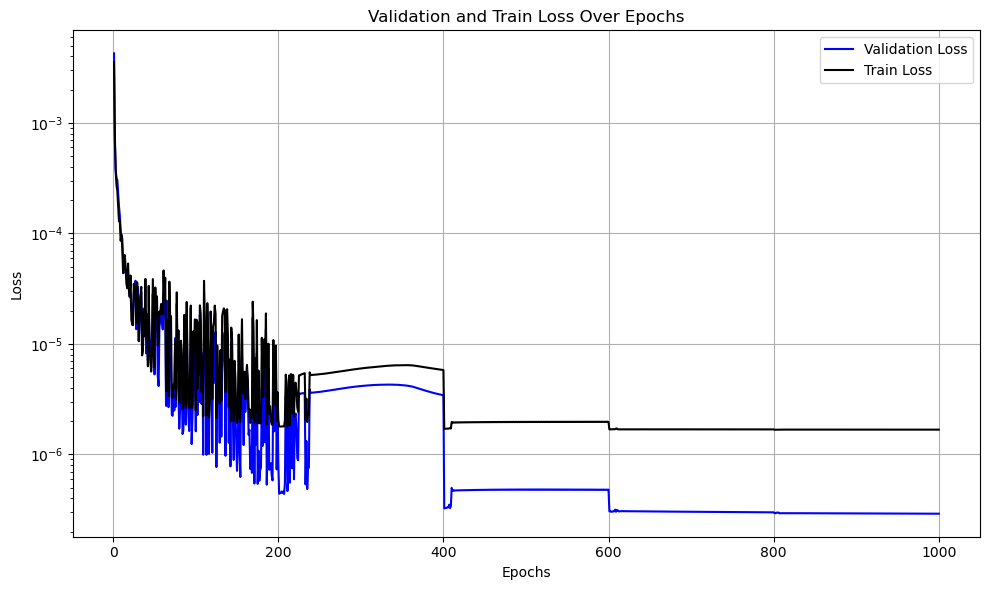

In [106]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='blue')
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='black')
plt.title('Validation and Train Loss Over Epochs')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
#plt.xticks(range(1, epochs + 1))
plt.tight_layout()

# Save or show the plot
plt.savefig('OU_loss_curve.png')
plt.show()

In [107]:
def eval_state(path, gelu=False, soft=False):
    best_state = torch.load(path)
    best_model = net(n_input, 200, 200, 200, n_output, gelu, soft)
    best_model.load_state_dict(best_state["model_state_dict"])
    best_model.to(device)
    best_model.eval()
    with torch.no_grad():
        test_predictions = best_model(test_X_tensor)
    hpred = test_predictions.squeeze().detach().cpu().numpy()
    htarget = test_y_tensor.squeeze().cpu().numpy()
    herrors = shuffled_test[" 95cI"].to_numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].scatter(htarget, hpred, s=1, alpha=0.1)
    axs[0].scatter(np.sort(htarget[:1024]), np.sort(hpred[:1024]), s=1, alpha=0.1)
    minn = min(htarget)
    maxx = max(htarget)
    rho = np.mean((htarget - htarget.mean()) * (hpred - hpred.mean())) / np.std(htarget) / np.std(hpred)
    r2 = 1 - np.sum((hpred - htarget)**2) / np.sum((htarget - np.mean(htarget))**2)
    accurate = np.sum(((htarget - herrors - 1e-6) < hpred) * ((htarget + herrors + 1e-6) > hpred))/ htarget.shape[0]
    accurate_relaxed = np.sum(((htarget - 2*herrors - 1e-6) < hpred) * ((htarget + 2*herrors + 1e-6) > hpred))/ htarget.shape[0]
    print(f"linear corr: {rho}, r2: {r2}, acc: {accurate}, acc relaxed: {accurate_relaxed}")
    axs[0].plot([minn, maxx], [minn, maxx], color='C3')
    axs[1].ecdf(htarget)
    axs[1].ecdf(hpred)
    plt.show()
    plt.close()
    return hpred

linear corr: 0.9999808073043823, r2: 0.9999614950174873, acc: 0.8412215605828715, acc relaxed: 0.9593584813447713


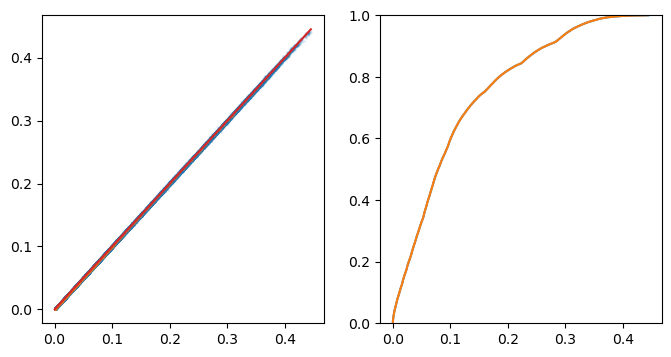

array([5.8099777e-02, 4.5781759e-05, 5.5371609e-02, ..., 6.3521124e-02,
       2.2805517e-04, 5.6732367e-03], dtype=float32)

In [110]:
eval_state("D:/etud/Brice/alt4_checkpoints/best_model.pth", True, True)